In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
from scipy.interpolate import interp1d
import os
import sys
from matplotlib.colors import LinearSegmentedColormap

cwd = os.getcwd()
model_path = os.path.abspath(os.path.join(cwd, os.pardir, 'models'))
sys.path.append(model_path)
from cumul_diamond_ODE_model import *
from cumul_treated_diamond_ODE_model import *

In [ ]:
# Load models
untreated_model = cumulDiamondODEModel()
treated_model = cumulTreatedDiamondODEModel()

t_final = 31
Np = 2666 # Number of passengers
Nc = 1045 # Number of crew
n_tot = 100 # Number of simulations
times = np.linspace(0, t_final, n_tot) # Simulated timepoints

# Load data
data = pd.read_csv('../data/data_cases_symp.csv')
data['onset_date'] = pd.to_datetime(data['onset_date'], format='%d-%b')

# Load model simulations
untreated_df = pd.read_csv('../data/untreated_simulations.csv')
treated_df = pd.read_csv('../data/treated_simulations.csv')
coverage_efficacy_df = pd.read_csv('../data/efficacy_coverage_percent_infections_averted.csv')
results_df = pd.read_csv('../data/passengers_crew_infections_averted_efficacy.csv')  # Load from CSV
heatmap_df = pd.read_csv('../data/starttime_coverage_percent_infections_averted.csv', index_col=0)

In [ ]:
# Identify structure
state_cols = [col for col in untreated_df.columns if col.startswith('state_')]

# Reconstruct list of arrays (shape: n_tot * n_states per sim)
all_untreated_simulated_values = []

for sim_id in sorted(untreated_df['simulation'].unique()):
    subset = untreated_df[untreated_df['simulation'] == sim_id]
    subset = subset.sort_values(by='time')
    sim_array = subset[state_cols].to_numpy()
    all_untreated_simulated_values.append(sim_array)

# Ensure proper sorting
treated_df = treated_df.sort_values(by=['simulation', 'intervention_time', 'time'])

# Reconstruct nested list of dictionaries
all_treated_simulated_values = []

simulations = sorted(treated_df['simulation'].unique())
intervention_times = sorted(treated_df['intervention_time'].unique())
state_cols = [col for col in treated_df.columns if col.startswith('state_')]

for sim in simulations:
    sim_dict = {}
    sim_subset = treated_df[treated_df['simulation'] == sim]
    
    for t in intervention_times:
        subset = sim_subset[sim_subset['intervention_time'] == t]
        if subset.empty:
            sim_dict[t] = None
        else:
            sim_dict[t] = subset[state_cols].to_numpy()
    
    all_treated_simulated_values.append(sim_dict)

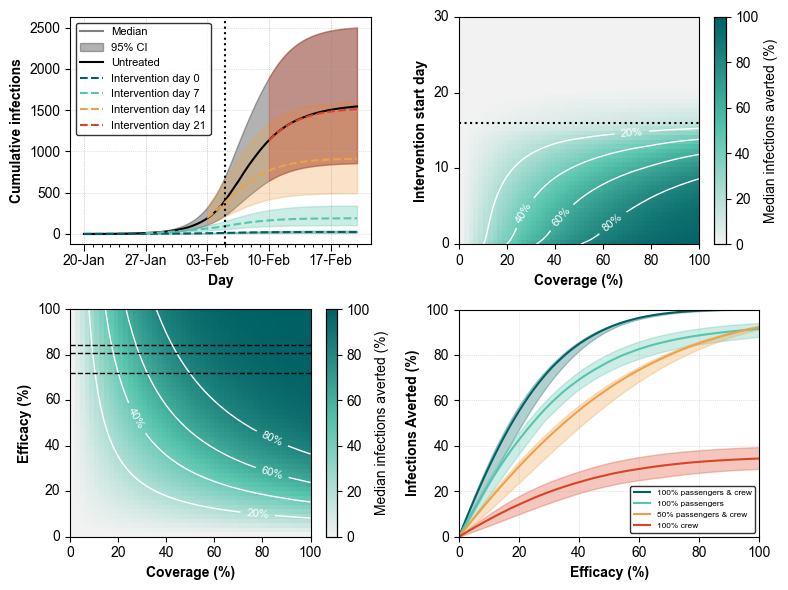

In [ ]:
# Rename coverage columns to percentages
heatmap_df.columns = [int(c * 100) for c in heatmap_df.columns.astype(float)]

# --- Custom colormap ---
colorscale = ['#F2F2F2', '#57C4AD', '#006164']
custom_cmap = LinearSegmentedColormap.from_list('custom_teal', colorscale)

# --- Create 2x2 grid ---
plt.rcParams['font.family'] = 'Arial'
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# --- Top-left: existing cumulative infections plot ---
ax = axs[0, 0]
colors = ['#006164', '#57C4AD', '#EDA247', '#DB4325']
ax.plot(np.nan, np.nan, label='Median', color='grey')
ax.fill_between([np.nan, np.nan], [np.nan, np.nan], [np.nan, np.nan], color='black', alpha=0.3, label='95% CI')

# Plotting untreated
untreated_total = np.array([sim[:, -2] + sim[:, -1] for sim in all_untreated_simulated_values])
untreated_lower, untreated_upper = np.percentile(untreated_total, [2.5, 97.5], axis=0)
untreated_median = np.median(untreated_total, axis=0)
ax.fill_between(times, untreated_lower, untreated_upper, color='black', alpha=0.3)
ax.plot(times, untreated_median, label='Untreated', color='black')

# Plotting treated
t_interventions = [0, 7, 14, 21]
for idx, t_intervention in enumerate(t_interventions):
    treated_time = np.linspace(t_intervention, t_final, int((t_final - t_intervention) * n_tot / t_final))
    treated_total = np.array([sim[t_intervention][:, 22] + sim[t_intervention][:, 23] for sim in all_treated_simulated_values])
    treated_lower, treated_upper = np.percentile(treated_total, [2.5, 97.5], axis=0)
    treated_median = np.median(treated_total, axis=0)
    ax.fill_between(treated_time, treated_lower, treated_upper, color=colors[idx], alpha=0.3)
    ax.plot(treated_time, treated_median, '--', label=f'Intervention day {t_intervention}', color=colors[idx])

ax.set_xlabel('Day', weight='bold')
ax.set_ylabel('Cumulative infections', weight='bold')
ax.legend(loc='upper left', edgecolor='black', fontsize=8)

# Tick formatting
full_indices = data.index
full_dates = data['onset_date'].dt.strftime('%d-%b')
label_interval = 7
labels = ['' if (i % label_interval != 0) else date for i, date in enumerate(full_dates)]
ax.set_xticks(full_indices)
ax.set_xticklabels(labels)
for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    size = 5 if i % label_interval == 0 else 2
    tick.tick1line.set_markersize(size)
    tick.tick2line.set_markersize(size)

ax.axvline(x=16, color='black', linestyle=':')
ax.grid(axis='y', linestyle=':', linewidth=0.5, alpha=0.7)
# Add vertical grid lines every 7 ticks only
for i, tick in enumerate(ax.get_xticks()):
    if i % 7 == 0:
        ax.axvline(x=tick, color='grey', linestyle=':', linewidth=0.5, alpha=0.7)

# --- Top-right: Heatmap of % infections averted ---
ax2 = axs[0, 1]
im = sns.heatmap(heatmap_df, cmap=custom_cmap, annot=False, fmt='.1f', cbar=True,
            vmin=0, vmax=100, ax=ax2, cbar_kws={'label': 'Median infections averted (%)'})
ax2.set_xlabel('Coverage (%)', weight='bold')
ax2.set_ylabel('Intervention start day', weight='bold')
ax2.axhline(y=16*50/30, color='black', linestyle=':')
ax2.invert_yaxis()

ax2.set_xticks([0, 10, 20, 30, 40, 50])
ax2.set_xticklabels(['0', '20', '40', '60', '80', '100'], rotation=0)

ax2.set_yticks([0, 50/3, 2*50/3, 50])
ax2.set_yticklabels(['0', '10', '20', '30'], rotation=0)

# Plot contours
contour_levels = [20, 40, 60, 80]

# Coordinates: 0 to 49 (position indices)
x = np.arange(heatmap_df.shape[1]) + 1
y = np.arange(heatmap_df.shape[0]) + 1
X, Y = np.meshgrid(x, y)
Z = heatmap_df.values
Z = np.flipud(heatmap_df.values)
Y = np.arange(heatmap_df.shape[0])[::-1]  # 49 → 0
X, Y = np.meshgrid(x, Y)

# Plot contours
contours = ax2.contour(X, Y, Z, levels=contour_levels, colors='white', linewidths=1)
ax2.clabel(contours, inline=True, fmt='%d%%', fontsize=8)

for label in ax2.get_xticklabels():
    label.set_rotation(0)
for label in ax2.get_yticklabels():
    label.set_rotation(0)

# Add box around the entire heatmap
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(ax.spines['left'].get_linewidth())

cbar = im.collections[0].colorbar
for spine in cbar.ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(ax.spines['left'].get_linewidth())


# --- Bottom-left: Heatmap of % infections averted by efficacy vs coverage ---
bottom_left_ax = axs[1, 0]

# Load and process the df (replace with your actual DataFrame if already loaded)

# Create pivot table
pivot = coverage_efficacy_df.pivot_table(
    values='Percentage Averted',
    index='Efficacy',
    columns='Coverage'
)

# Convert to % scale for x-axis
pivot.columns = [round(c * 100) for c in pivot.columns]
pivot.index = [round(i * 100) for i in pivot.index]

# Plot heatmap
im2 = sns.heatmap(
    pivot*100,
    ax=bottom_left_ax,
    cmap=custom_cmap,
    annot=False,
    fmt='.1f',
    cbar=True,
    vmin=0,
    vmax=100,
    cbar_kws={'label': 'Median infections averted (%)'}
)

bottom_left_ax.set_xlabel('Coverage (%)', weight='bold')
bottom_left_ax.set_ylabel('Efficacy (%)', weight='bold')
bottom_left_ax.invert_yaxis()

bottom_left_ax.set_xticks([0, 10, 20, 30, 40, 50])
bottom_left_ax.set_xticklabels(['0', '20', '40', '60', '80', '100'], rotation=0)
bottom_left_ax.set_yticks([0, 10, 20, 30, 40, 50])
bottom_left_ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], rotation=0)

# Tick label styling
for label in bottom_left_ax.get_xticklabels():
    label.set_rotation(0)
for label in bottom_left_ax.get_yticklabels():
    label.set_rotation(0)

# Add box around heatmap
for spine in bottom_left_ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(ax.spines['left'].get_linewidth())

# Colorbar border matching
cbar2 = im2.collections[0].colorbar
for spine in cbar2.ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(ax.spines['left'].get_linewidth())

# Generate contour data from the same matrix (pivot * 100 for %)
Z2 = pivot.values * 100  # shape (rows, cols) = (efficacy levels, coverage levels)

# Use index positions for alignment (0 to N-1)
x2 = np.arange(Z2.shape[1]) + 1  # coverage positions (cols)
y2 = np.arange(Z2.shape[0]) + 1 # efficacy positions (rows)

# Flip Z and Y to match inverted Y axis
Z2_flipped = np.flipud(Z2)
y2_flipped = y2[::-1]

# Meshgrid
X2, Y2 = np.meshgrid(x2, y2_flipped)

# Plot contours
contour_levels = [20, 40, 60, 80, 100]
contours2 = bottom_left_ax.contour(X2, Y2, Z2_flipped, levels=contour_levels, colors='white', linewidths=1)

# Add contour labels
bottom_left_ax.clabel(contours2, inline=True, fmt='%d%%', fontsize=8)

bottom_left_ax.axhline(72/2, color='black', linestyle='--', linewidth=1)
bottom_left_ax.axhline(80.92/2, color='black', linestyle='--', linewidth=1)
bottom_left_ax.axhline(84.4/2, color='black', linestyle='--', linewidth=1)


# --- Bottom-right: Median and 95% CI vs efficacy for each coverage combination ---
bottom_right_ax = axs[1, 1]

# Get unique coverage combinations
unique_coverages = results_df[['Passenger Coverage', 'Crew Coverage']].drop_duplicates().values

# --- Define fixed colors and labels for each unique coverage combo ---
coverage_styles = {
    (1.0, 1.0): {'color': '#006164', 'label': '100% passengers & crew'},
    (1.0, 0.0): {'color': '#57C4AD', 'label': '100% passengers'},
    (0.5, 0.5): {'color': '#EDA247', 'label': '50% passengers & crew'},
    (0.0, 1.0): {'color': '#DB4325', 'label': '100% crew'},
}

# Plot for each unique coverage combination
for cov, style in coverage_styles.items():
    subset = results_df[
        (results_df['Passenger Coverage'] == cov[0]) & (results_df['Crew Coverage'] == cov[1])
    ]
    bottom_right_ax.plot(
        subset['Efficacy'] * 100,
        subset['Median Percentage Infections Averted'],
        label=style['label'],
        color=style['color']
    )
    bottom_right_ax.fill_between(
        subset['Efficacy'] * 100,
        subset['2.5th Percentile Percentage Infections Averted'],
        subset['97.5th Percentile Percentage Infections Averted'],
        color=style['color'],
        alpha=0.3
    )

bottom_right_ax.set_xlabel('Efficacy (%)', weight='bold')
bottom_right_ax.set_ylabel('Infections Averted (%)', weight='bold')
bottom_right_ax.set_xlim(0, 100)
bottom_right_ax.set_ylim(0, 100)
bottom_right_ax.legend(fontsize=6, loc='lower right', frameon=True, edgecolor='black')
bottom_right_ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()
